# Electron Crystals

This code investigates the Wigner crystal electron potential and the stability of states within this model. This analyzes the 2D interactions of electrons to better understand how large-scale structures form in matter.

In [2]:
import numpy as np
from random import random
from math import sqrt

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
def sgn(x):
   if x < 0.:    return -1.
   elif x > 0.:  return 1.
   else:         return 0.

In [4]:
def update(r, rprev, params, myf, fm):
   # unpack params
   (N, L, dt, rcut) = params

   # storage for updated position and current velocity
   rnew = np.zeros( (N, 2) )
   v = np.zeros( (N, 2) )

   # Verlet update
   for i in range(N):
      # compute total force
      fxTot, fyTot = 0., 0.
      for j in range(N):
         if j == i: continue   # no self-interaction
         # relative position - take nearest separation (periodic BC)
         xij = r[i,0] - r[j,0]
         yij = r[i,1] - r[j,1]
         if abs(xij) > L * 0.5:
           xij -= sgn(xij) * L
         if abs(yij) > L * 0.5:
           yij -= sgn(yij) * L * myf
         rij = sqrt(xij**2 + yij**2)
         # skip r > rcut
         if rij > rcut: continue
         # force j->i
         fjiMagnitude = fm * ((1 / rij**2) - ((1/2) / (rij**3 + 0.025)))
         fxTot += fjiMagnitude * xij / rij
         fyTot += (fjiMagnitude * yij / rij)
      # new positions and velocities from Verlet
      xnew = 2. * r[i,0] - rprev[i,0] + dt**2 * fxTot
      ynew = 2. * r[i,1] - rprev[i,1] + dt**2 * fyTot
      v[i,0] = (xnew - rprev[i,0]) / (2. * dt)
      v[i,1] = (ynew - rprev[i,1]) / (2. * dt)
      # employ periodic BC, then store position
      if   xnew < 0.:
         xnew += L
         r[i,0] += L
      elif xnew > L:
         xnew -= L
         r[i,0] -= L
      if   ynew < 0.:
         ynew += L
         r[i,1] += L
      elif ynew > L:
         ynew -= L
         r[i,1] -= L
      rnew[i,0] = xnew
      rnew[i,1] = ynew
   # return new position, current position, and current velocity arrays
   return rnew, r, v

In [5]:
def plotParticles(ax0, r, L, pointarea):
   ax0.set_xlim( [0, L] )
   ax0.set_ylim( [0, L] )
   #
   ax0.scatter(r[:,0], r[:,1], s = pointarea, color = "red")     # used red, except
   ax0.scatter(r[0,0], r[0,1], s = pointarea, color = "red")    # particle 1 is in blue 
   ax0.scatter(r[1,0], r[1,1], s = pointarea, color = "red")   # particle 2 is in green

In [6]:
def runnr(N, L, dt, tf, myf, fm, plotFreq, vmax, dmax, plotInter, plotFinal):
    rcut = 3.   # cutoff for interaction: r > 3
    
    pointarea = 80. * (20. / N)**2   # scale to N = 20 

    params = (N, L, dt, rcut)


    # initial conditions
    #

    r     = np.zeros( (N, 2) )   # current position
    rprev = np.zeros( (N, 2) )   # prev position
    v     = np.zeros( (N, 2) )   # current velocity

    # arrange particles on a rectangular grid, to keep them apart initially
    # - use smallest grid that can house them
    # - grid only partially filled if N is not square
    Ngrid = int(sqrt(N))
    if Ngrid != sqrt(N):
       Ngrid += 1
    Lgrid = L / Ngrid

    for k in range(N):
       # row, column and corresponding position (sqrt(2) factors maintain parity with old Matlab version)
       i, j = k // Ngrid,  k % Ngrid
       r[k,0] = (i + 0.5) * Lgrid + (random() - 0.5) * dmax * Lgrid * sqrt(2.)
       r[k,1] = (j + 0.5) * Lgrid + (random() - 0.5) * dmax * Lgrid * sqrt(2.)
       # velocity
       v[k,0] = vmax * (random() - 0.5) * sqrt(2.)
       v[k,1] = vmax * (random() - 0.5) * sqrt(2.)
       # previous position (assumes no interaction before t = 0)
       rprev[k,0] = r[k,0] - v[k,0] * dt
       rprev[k,1] = r[k,1] - v[k,1] * dt



    # display initial configuration
    #

    fontsize = 15   # fontsize, need to be tuned to screen resolution
    linewidth = 3

    output = []

    t = 0.
    doPlot = True

    while True:
       if ((int((t + dt) / dt) % int(plotFreq) == 0) or (int(t/dt) == 0)):
          fig, axArray = plt.subplots(1, 1)
          (ax0) = axArray
          ax0.tick_params(labelsize = fontsize)
          plotParticles(ax0, r, L, pointarea)
          ax0.scatter(r[:,0], r[:,1], s = pointarea, color = "green", facecolors = "none", linewidth = 1)
          titleStr = "t=" + str(round(t, 4))
          ax0.set_title(titleStr, fontsize = fontsize)
          ax0.set_aspect(1)
          plt.show()
            
       r, rprev, v = update(r, rprev, params, myf, fm)
       t += dt
       # physics output
       # - |r|^2 for particle 1, and |r1-r2|^2 for particles 1 & 2
       r1sq  = rprev[0,0]**2 + rprev[0,1]**2
       r12sq = (rprev[0,0] - rprev[1,0])**2 + (rprev[0,1] - rprev[1,1])**2
        
       if(t >= tf):
        break

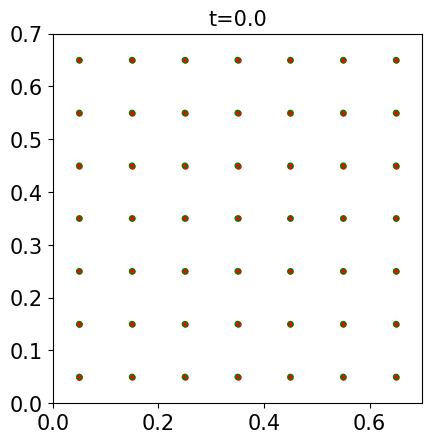

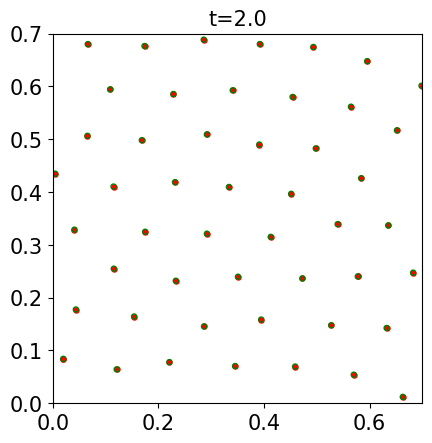

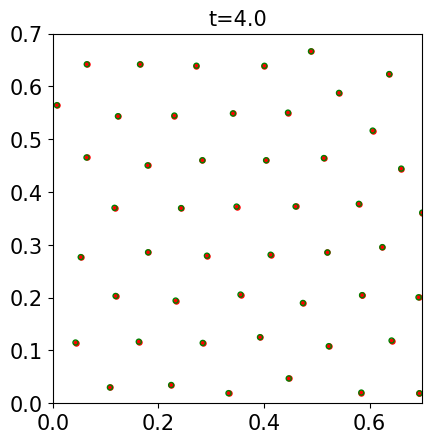

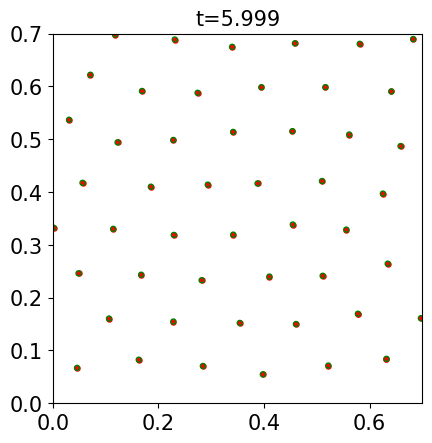

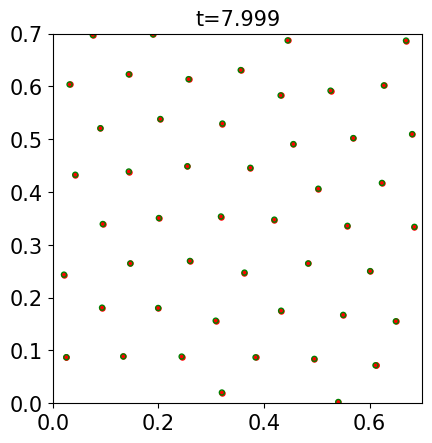

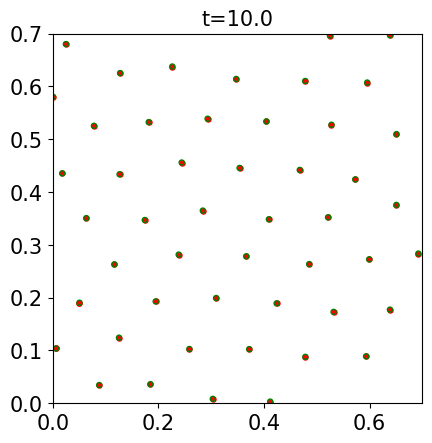

In [7]:
N    =        49
L    =        7 * 0.1
dt   =        0.001
tf   =        10
myf  =        1.
fm   =        50.
dplot =       2
plotFreq =    int(dplot / dt)
vmax =        1 * (10 ** (-9))
dmax =        1 * (10 ** (-10)) 

runnr(N, L, dt, tf, myf, fm, plotFreq, vmax, dmax, True, True)

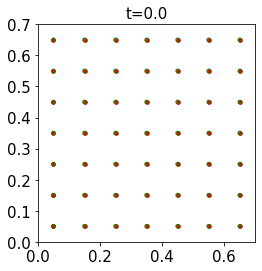

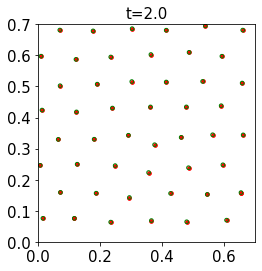

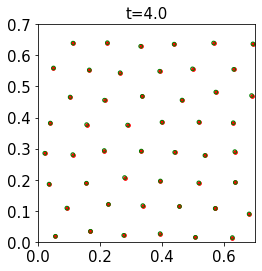

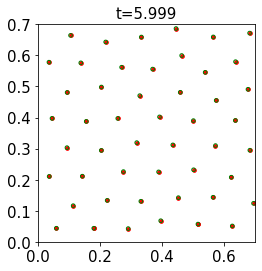

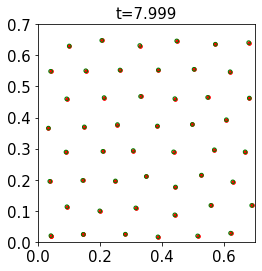

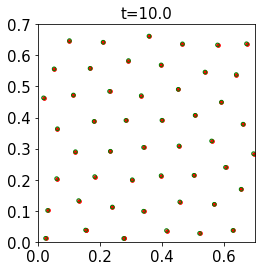

In [218]:
#introduce anisotropy, favor y

N    =        49
L    =        7 * 0.1
dt   =        0.001
tf   =        10
myf  =        1.0 + 0.001
fm   =        50.
dplot =       2
plotFreq =    int(dplot / dt)
vmax =        1 * (10 ** (-9))
dmax =        1 * (10 ** (-10)) 

runnr(N, L, dt, tf, myf, fm, plotFreq, vmax, dmax, True, True)

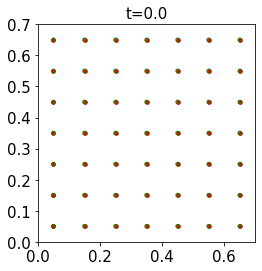

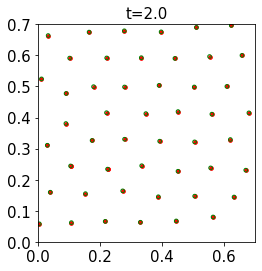

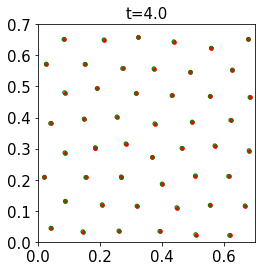

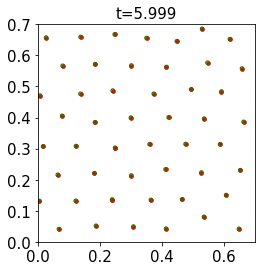

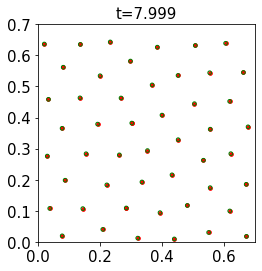

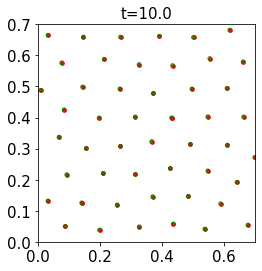

In [219]:
#introduce anisotropy, favor x

N    =        49
L    =        7 * 0.1
dt   =        0.001
tf   =        10
myf  =        1.0 - 0.001
fm   =        50.
dplot =       2
plotFreq =    int(dplot / dt)
vmax =        1 * (10 ** (-9))
dmax =        1 * (10 ** (-10)) 

runnr(N, L, dt, tf, myf, fm, plotFreq, vmax, dmax, True, True)